In [1]:
import gpytorch
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option("display.max_rows", None)
np.random.seed(42)

# Data Preparation

In [2]:
# import the dataset

currency_df = pd.read_csv('currency_exchange_rates_02-01-1995_-_02-05-2018.csv')
currency_df.head(5)

,Date,Algerian Dinar,Australian Dollar,Bahrain Dinar,Bolivar Fuerte,Botswana Pula,Brazilian Real,Brunei Dollar,Canadian Dollar,Chilean Peso,...,South African Rand,Sri Lanka Rupee,Swedish Krona,Swiss Franc,Thai Baht,Trinidad And Tobago Dollar,Tunisian Dinar,U.A.E. Dirham,U.K. Pound Sterling,U.S. Dollar
0,1995-1-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,1995-1-3,NaN,NaN,0.376,NaN,NaN,0.843,NaN,1.4035,NaN,...,3.55,50.04,7.4588,1.3168,25.10,5.8750,NaN,3.671,1.5617,1.0
2,1995-1-4,NaN,0.7704,0.376,NaN,NaN,0.844,NaN,1.4026,NaN,...,3.56,50.07,7.4480,1.3161,25.13,5.8738,NaN,3.671,1.5605,1.0
3,1995-1-5,NaN,0.7693,0.376,NaN,NaN,0.844,NaN,1.4002,NaN,...,3.55,50.07,7.4450,1.3080,25.14,5.8700,NaN,3.671,1.5610,1.0
4,1995-1-6,NaN,0.7699,0.376,NaN,NaN,0.842,NaN,1.4002,NaN,...,3.56,50.07,NaN,1.3040,25.13,5.8810,NaN,3.671,1.5645,1.0


In [3]:
# create a subset of currencies

currency_subset_df = currency_df[['Date', 'Australian Dollar', 
       'Brazilian Real', 'Canadian Dollar', 'Chinese Yuan', 'Euro', 'Indian Rupee',
       'Iranian Rial', 'Israeli New Sheqel', 'Japanese Yen', 
       'Korean Won', 'Malaysian Ringgit', 'Mexican Peso',  
       'Saudi Arabian Riyal', 'Singapore Dollar',
       'South African Rand', 'Swedish Krona', 'Swiss Franc',
       'Thai Baht',  'U.K. Pound Sterling', 'U.S. Dollar']]

currency_subset_df.head(5)

,Date,Australian Dollar,Brazilian Real,Canadian Dollar,Chinese Yuan,Euro,Indian Rupee,Iranian Rial,Israeli New Sheqel,Japanese Yen,...,Malaysian Ringgit,Mexican Peso,Saudi Arabian Riyal,Singapore Dollar,South African Rand,Swedish Krona,Swiss Franc,Thai Baht,U.K. Pound Sterling,U.S. Dollar
0,1995-1-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,1995-1-3,NaN,0.843,1.4035,NaN,NaN,31.37,1753.998616,NaN,NaN,...,2.5525,NaN,3.745,1.4563,3.55,7.4588,1.3168,25.10,1.5617,1.0
2,1995-1-4,0.7704,0.844,1.4026,NaN,NaN,31.37,1753.525647,NaN,100.98,...,2.5510,NaN,3.745,1.4537,3.56,7.4480,1.3161,25.13,1.5605,1.0
3,1995-1-5,0.7693,0.844,1.4002,NaN,NaN,31.37,1746.890000,NaN,101.00,...,2.5488,NaN,3.745,1.4520,3.55,7.4450,1.3080,25.14,1.5610,1.0
4,1995-1-6,0.7699,0.842,1.4002,NaN,NaN,31.37,1744.746721,NaN,100.95,...,2.5497,NaN,3.745,1.4527,3.56,NaN,1.3040,25.13,1.5645,1.0


In [4]:
# kick out everything before the inception of the EURO on 30-10-1998 (index = 992)

currency_subset_euro_df = currency_subset_df.iloc[992:, :]
currency_subset_euro_df.head(5)

,Date,Australian Dollar,Brazilian Real,Canadian Dollar,Chinese Yuan,Euro,Indian Rupee,Iranian Rial,Israeli New Sheqel,Japanese Yen,...,Malaysian Ringgit,Mexican Peso,Saudi Arabian Riyal,Singapore Dollar,South African Rand,Swedish Krona,Swiss Franc,Thai Baht,U.K. Pound Sterling,U.S. Dollar
992,1998-10-30,0.6263,1.1914,1.5425,NaN,1.18398,42.37,1751.65264,NaN,116.40,...,3.8,NaN,3.745,1.622,5.6570,7.8230,1.3459,36.771,1.6773,1.0
993,1998-11-2,0.6259,NaN,1.5318,NaN,1.18373,42.30,1751.36597,NaN,115.30,...,3.8,NaN,3.745,1.619,5.6165,7.7490,1.3477,36.683,1.6676,1.0
994,1998-11-3,0.6237,1.1924,1.5238,8.2777,1.17525,42.29,1755.43923,NaN,NaN,...,3.8,NaN,3.745,1.624,5.6015,7.8235,1.3561,36.679,1.6552,1.0
995,1998-11-4,0.6308,1.1921,1.5238,NaN,1.17110,42.29,1759.42190,NaN,115.85,...,3.8,NaN,3.745,1.621,5.5965,7.8133,1.3689,36.575,1.6527,1.0
996,1998-11-5,0.6314,1.1908,1.5176,NaN,1.17706,42.35,1750.01488,NaN,117.60,...,3.8,NaN,3.745,1.624,5.5865,7.8080,1.3639,36.442,1.6594,1.0


In [5]:
# fill NaNs with bfill

currency_subset_euro_df = currency_subset_euro_df.fillna(method='bfill')

# now fill all NaNs at the end
currency_subset_euro_df = currency_subset_euro_df.fillna(method='ffill')

currency_subset_euro_df.head(5)

,Date,Australian Dollar,Brazilian Real,Canadian Dollar,Chinese Yuan,Euro,Indian Rupee,Iranian Rial,Israeli New Sheqel,Japanese Yen,...,Malaysian Ringgit,Mexican Peso,Saudi Arabian Riyal,Singapore Dollar,South African Rand,Swedish Krona,Swiss Franc,Thai Baht,U.K. Pound Sterling,U.S. Dollar
992,1998-10-30,0.6263,1.1914,1.5425,8.2777,1.18398,42.37,1751.65264,4.217,116.40,...,3.8,9.9998,3.745,1.622,5.6570,7.8230,1.3459,36.771,1.6773,1.0
993,1998-11-2,0.6259,1.1924,1.5318,8.2777,1.18373,42.30,1751.36597,4.217,115.30,...,3.8,9.9998,3.745,1.619,5.6165,7.7490,1.3477,36.683,1.6676,1.0
994,1998-11-3,0.6237,1.1924,1.5238,8.2777,1.17525,42.29,1755.43923,4.217,115.85,...,3.8,9.9998,3.745,1.624,5.6015,7.8235,1.3561,36.679,1.6552,1.0
995,1998-11-4,0.6308,1.1921,1.5238,8.2777,1.17110,42.29,1759.42190,4.217,115.85,...,3.8,9.9998,3.745,1.621,5.5965,7.8133,1.3689,36.575,1.6527,1.0
996,1998-11-5,0.6314,1.1908,1.5176,8.2777,1.17706,42.35,1750.01488,4.217,117.60,...,3.8,9.9998,3.745,1.624,5.5865,7.8080,1.3639,36.442,1.6594,1.0


In [6]:
import datetime as dt

currency_subset_euro_df['Date'] = pd.to_datetime(currency_subset_euro_df['Date'], errors='coerce')

currency_subset_euro_df['Day'] = currency_subset_euro_df['Date'].dt.day
currency_subset_euro_df['Month'] = currency_subset_euro_df['Date'].dt.month
currency_subset_euro_df['Year'] = currency_subset_euro_df['Date'].dt.year

currency_subset_euro_df = currency_subset_euro_df.reset_index(drop=True)
currency_subset_euro_df.head(5)

,Date,Australian Dollar,Brazilian Real,Canadian Dollar,Chinese Yuan,Euro,Indian Rupee,Iranian Rial,Israeli New Sheqel,Japanese Yen,...,Singapore Dollar,South African Rand,Swedish Krona,Swiss Franc,Thai Baht,U.K. Pound Sterling,U.S. Dollar,Day,Month,Year
0,1998-10-30,0.6263,1.1914,1.5425,8.2777,1.18398,42.37,1751.65264,4.217,116.40,...,1.622,5.6570,7.8230,1.3459,36.771,1.6773,1.0,30,10,1998
1,1998-11-02,0.6259,1.1924,1.5318,8.2777,1.18373,42.30,1751.36597,4.217,115.30,...,1.619,5.6165,7.7490,1.3477,36.683,1.6676,1.0,2,11,1998
2,1998-11-03,0.6237,1.1924,1.5238,8.2777,1.17525,42.29,1755.43923,4.217,115.85,...,1.624,5.6015,7.8235,1.3561,36.679,1.6552,1.0,3,11,1998
3,1998-11-04,0.6308,1.1921,1.5238,8.2777,1.17110,42.29,1759.42190,4.217,115.85,...,1.621,5.5965,7.8133,1.3689,36.575,1.6527,1.0,4,11,1998
4,1998-11-05,0.6314,1.1908,1.5176,8.2777,1.17706,42.35,1750.01488,4.217,117.60,...,1.624,5.5865,7.8080,1.3639,36.442,1.6594,1.0,5,11,1998


In [7]:
currency_subset_euro_df.columns

Index(['Date', 'Australian Dollar', 'Brazilian Real', 'Canadian Dollar',
       'Chinese Yuan', 'Euro', 'Indian Rupee', 'Iranian Rial',
       'Israeli New Sheqel', 'Japanese Yen', 'Korean Won', 'Malaysian Ringgit',
       'Mexican Peso', 'Saudi Arabian Riyal', 'Singapore Dollar',
       'South African Rand', 'Swedish Krona', 'Swiss Franc', 'Thai Baht',
       'U.K. Pound Sterling', 'U.S. Dollar', 'Day', 'Month', 'Year'],
      dtype='object')

In [8]:
# let's plot this mess

dates = currency_subset_euro_df['Date']
years = currency_subset_euro_df['Year']
australian_dollar = currency_subset_euro_df['Australian Dollar']
brazilian_real = currency_subset_euro_df['Brazilian Real']
canadian_dollar = currency_subset_euro_df['Canadian Dollar']
chinese_yuan = currency_subset_euro_df['Chinese Yuan']
euro = currency_subset_euro_df['Euro']
indian_rupee = currency_subset_euro_df['Indian Rupee']
iranian_rial = currency_subset_euro_df['Iranian Rial']
israeli_sheqel = currency_subset_euro_df['Israeli New Sheqel']
japanese_yen = currency_subset_euro_df['Japanese Yen']
korean_won = currency_subset_euro_df['Korean Won']
malaysian_ringgit = currency_subset_euro_df['Malaysian Ringgit']
mexican_peso = currency_subset_euro_df['Mexican Peso']
saudi_arabian_riyal = currency_subset_euro_df['Saudi Arabian Riyal']
singapore_dollar = currency_subset_euro_df['Singapore Dollar']
south_african_rand = currency_subset_euro_df['South African Rand']
swedish_krona = currency_subset_euro_df['Swedish Krona']
swiss_franc = currency_subset_euro_df['Swiss Franc']
thai_baht = currency_subset_euro_df['Thai Baht']
UK_pound = currency_subset_euro_df['U.K. Pound Sterling']
US_dollar = currency_subset_euro_df['U.S. Dollar']


In [9]:
value_counts = currency_subset_euro_df['Year'].value_counts()

year_idxs = []
idx = 0
for y in range(min(years), max(years)+1):
    year_idxs.append(idx)
    idx += value_counts[y]
    
    
print(year_idxs)

year_labels = years[year_idxs].values
print(year_labels)

[0, 44, 304, 563, 823, 1084, 1343, 1603, 1863, 2122, 2381, 2641, 2900, 3152, 3403, 3652, 3901, 4151, 4401, 4652, 4901]
[1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017 2018]


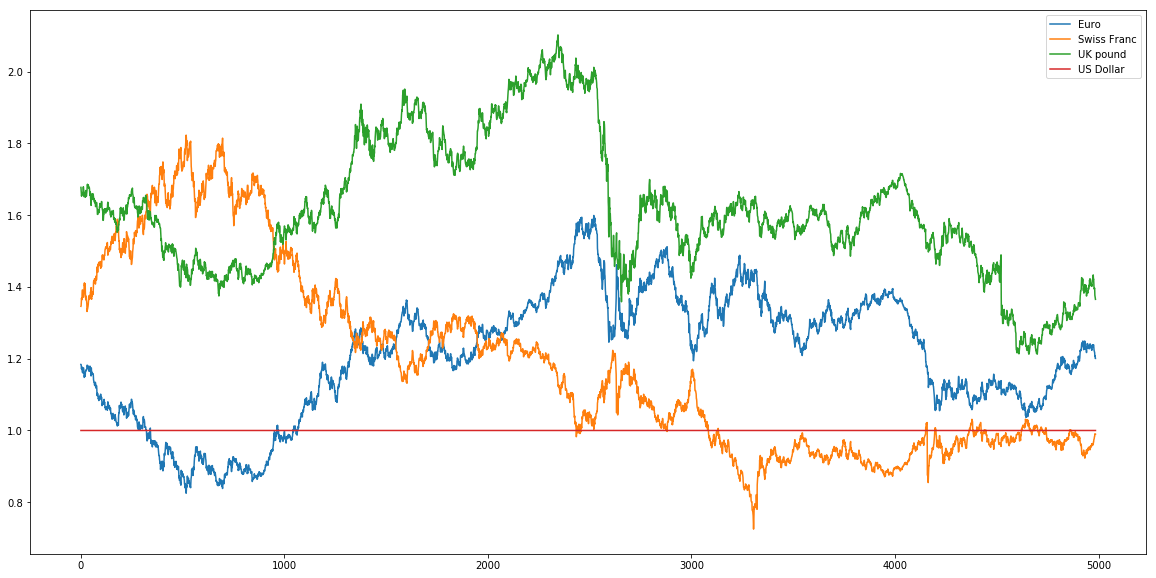

In [10]:
plt.rcParams["figure.figsize"] = (20,10)

#plt.plot(australian_dollar, label="Australian Dollar")
#plt.plot(brazilian_real, label="Brazilian Real")
#plt.plot(canadian_dollar, label="Canadian Dollar")
#plt.plot(chinese_yuan, label="Chinese Yuan")
plt.plot(euro, label="Euro")
#plt.plot(indian_rupee, label="Indian Rupee")
#plt.plot(iranian_rial, label="Iranian Rial")
#plt.plot(israeli_sheqel, label="Isreali New Sheqel")
#plt.plot(japanese_yen, label="Japanese Yen")
#plt.plot(korean_won, label="Korean Won")
#plt.plot(malaysian_ringgit, label="Malaysian Ringgit")
#plt.plot(mexican_peso, label="Mexican Peso")
#plt.plot(saudi_arabian_riyal, label="Saudi Arabian Riyal")
#plt.plot(singapore_dollar, label="Singapore Dollar")
#plt.plot(south_african_rand, label="South African Rand")
#plt.plot(swedish_krona, label="Swedish Krona")
plt.plot(swiss_franc, label="Swiss Franc")
#plt.plot(thai_baht, label="Thai Baht")
plt.plot(UK_pound, label="UK pound")
plt.plot(US_dollar, label="US Dollar")

plt.legend();
plt.show();

In [11]:
len(US_dollar)

4986

In [12]:
#plot the covariances for the EURO

covariances_ad = []

for index, row in currency_subset_euro_df.iterrows():
    
    z_i = row[['Euro', 'Swiss Franc', 'U.K. Pound Sterling', 'U.S. Dollar']]
    
    mu_i = z_i.mean()
    x_i = np.outer(z_i - mu_i, z_i - mu_i)
    
    covariances_ad.append(x_i[:,0])

In [13]:
covariances_ad = np.array(covariances_ad)
#var_ad = covariances_ad[:,0]
#std_ad = np.sqrt(var_ad)
cov_ad_euro = covariances_ad[:,0]
cov_ad_sf = covariances_ad[:,1]
cov_ad_pound = covariances_ad[:,2]
cov_ad_dollar = covariances_ad[:,3]

n_curr = 4

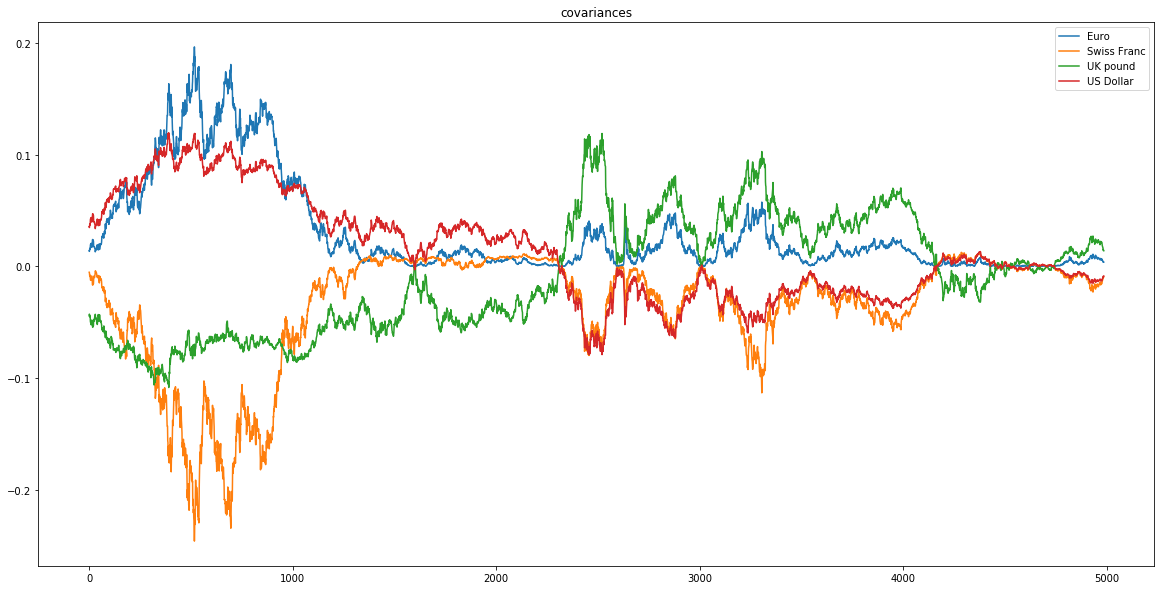

In [14]:
plt.rcParams["figure.figsize"] = (20,10)

#plt.plot(var_ad, label="Australian Dollar")
plt.plot(cov_ad_euro, label="Euro")
plt.plot(cov_ad_sf, label="Swiss Franc")
plt.plot(cov_ad_pound, label="UK pound")
plt.plot(cov_ad_dollar, label="US Dollar")
plt.title("covariances")

plt.legend();
plt.show();

# Start calculating

In [15]:
from copy import deepcopy

# specify simple priors
n_0 = n_curr
Psi_0 = 0.01 * np.eye(n_curr)

n_i = n_curr
Psi_i = deepcopy(Psi_0)

Psis = []
ns = []

prev_month = 10

for index, row in currency_subset_euro_df.iterrows():
    
    month = row['Month']

    z_i = row[['Euro', 'Swiss Franc', 'U.K. Pound Sterling', 'U.S. Dollar']]
    
    mu_i = z_i.mean()
    x_i = np.outer(z_i - mu_i, z_i - mu_i)
    x_i = x_i.astype('float')
    #print("x_i: ", x_i)
    
    #reset when new month starts
    if month != prev_month:
        ns.append(max(n_i, n_curr+1))
        #print("Psi: ", Psi_i)
        Psis.append(Psi_i)
        n_i = n_curr
        Psi_i = deepcopy(Psi_0)
        prev_month = month
        
    n_i += 1
    #print(np.shape(x_i))
    Psi_i += x_i

print(len(ns))
print(len(Psis))

235
235


In [16]:
print(ns)

[5, 25, 26, 24, 24, 27, 26, 25, 26, 26, 26, 26, 25, 26, 27, 25, 25, 27, 24, 27, 26, 25, 27, 25, 26, 26, 24, 26, 24, 26, 25, 27, 25, 26, 27, 24, 27, 26, 25, 27, 24, 25, 26, 27, 24, 27, 26, 25, 27, 25, 26, 26, 24, 25, 26, 26, 25, 27, 25, 26, 27, 24, 26, 25, 24, 27, 26, 24, 26, 26, 26, 26, 25, 26, 27, 25, 24, 27, 25, 26, 26, 25, 27, 26, 25, 26, 26, 26, 24, 27, 24, 27, 26, 25, 27, 25, 26, 26, 24, 26, 24, 26, 25, 27, 25, 26, 27, 24, 27, 26, 24, 26, 25, 25, 26, 26, 25, 27, 25, 26, 27, 24, 26, 25, 24, 26, 26, 25, 26, 27, 25, 26, 26, 25, 26, 24, 24, 27, 26, 24, 26, 25, 26, 25, 24, 24, 25, 24, 23, 27, 25, 25, 26, 24, 27, 25, 24, 24, 25, 24, 24, 26, 25, 26, 25, 25, 27, 23, 26, 24, 22, 25, 23, 25, 26, 26, 24, 25, 26, 24, 26, 23, 24, 25, 23, 25, 26, 25, 25, 26, 25, 25, 26, 22, 25, 23, 23, 26, 26, 24, 26, 26, 25, 25, 25, 23, 26, 23, 24, 27, 25, 25, 26, 24, 27, 25, 24, 24, 25, 23, 23, 27, 24, 26, 26, 24, 27, 24, 25, 24, 24, 25, 23, 26, 25]


In [17]:
print(Psis[:10])

[array([[ 0.02388037, -0.00519623, -0.04424012,  0.03555598],
       [-0.00519623,  0.01194525,  0.01656165, -0.01331067],
       [-0.04424012,  0.01656165,  0.15100401, -0.11332553],
       [ 0.03555598, -0.01331067, -0.11332553,  0.10108022]]), array([[ 0.41370388, -0.24097649, -1.04085312,  0.87812573],
       [-0.24097649,  0.15610573,  0.61392371, -0.51905295],
       [-1.04085312,  0.61392371,  2.71849352, -2.28156411],
       [ 0.87812573, -0.51905295, -2.28156411,  1.93249133]]), array([[ 0.37575261, -0.16815986, -1.04874563,  0.85115288],
       [-0.16815986,  0.09011789,  0.47633036, -0.38828839],
       [-1.04874563,  0.47633036,  3.03028468, -2.44786941],
       [ 0.85115288, -0.38828839, -2.44786941,  1.99500492]]), array([[ 0.39364784, -0.23682442, -0.9724045 ,  0.82558109],
       [-0.23682442,  0.15762032,  0.59593186, -0.50672775],
       [-0.9724045 ,  0.59593186,  2.49202863, -2.10555599],
       [ 0.82558109, -0.50672775, -2.10555599,  1.79670266]]), array([[ 0.6108

In [18]:
# transform all ns and Psis to mus and Sigmas through Laplace Propagation.
# we choose the exponential base as it has less approximations than the sqrtm

from scipy.linalg import expm, sqrtm, logm

def Inv_Wishart_logm_bridge_mu(Psi, v):
    p = np.shape(Psi)[0]
    r = logm(1/(v+p-1) * Psi)
    return(r.reshape(-1))
    
def Inv_Wishart_logm_bridge_Sigma(Psi, v):
    p = np.shape(Psi)[0]
    return(2 * (v+p-1) * np.eye(p**2))

def Inv_Wishart_sqrtm_bridge_mu(Psi, v):
    p = np.shape(Psi)[0]
    r =  sqrtm(1/(v+p)*Psi)
    return(r.reshape(-1))
    
def Inv_Wishart_sqrtm_bridge_Sigma(Psi, v):
    p = np.shape(Psi)[0]
    Psi_inv = np.linalg.inv(Psi)
    Psi_sqrtm = sqrtm(Psi)
    Psi_inv_sqrtm = np.linalg.inv(Psi_sqrtm)
    one = (v+p)**2 * (np.kron(Psi_inv_sqrtm@Psi_inv_sqrtm@Psi_inv_sqrtm, Psi_sqrtm)\
                         + np.kron(Psi_inv, np.eye(p)))

    
    R = np.linalg.inv(one)
    return(R) 


#helper functions
def is_pos_def(x):
    eig = np.linalg.eigvals(x)
    pd = np.all(eig > 0)
    if not pd:
        raise(ValueError("matrix is not positive definite! Matrix: {}; Eigenvalues: {}".format(x, eig)))
    else:
        return(True)

In [19]:
# get individual mus and Sigmas

Y_mu = []
Y_Sigma = []

for i, p_ in enumerate(Psis):
    n_ = ns[i]
    #mu_ = Inv_Wishart_logm_bridge_mu(p_, n_).real
    #Sigma_ = Inv_Wishart_logm_bridge_Sigma(p_, n_)
    mu_ = Inv_Wishart_sqrtm_bridge_mu(p_, n_)
    Sigma_ = Inv_Wishart_sqrtm_bridge_Sigma(p_, n_)
    Y_mu.append(mu_)
    Y_Sigma.append(Sigma_)
    
print(Y_mu[0])
print(Y_Sigma[0])

[ 0.04094509 -0.00284952 -0.02426051  0.01949828 -0.00284952  0.03440007
  0.00908212 -0.00729934 -0.02426051  0.00908212  0.11065746 -0.06214574
  0.01949828 -0.00729934 -0.06214574  0.08328013]
[[ 2.01680536e-04+0.j  2.07311873e-06+0.j  1.76502993e-05+0.j
  -1.41856222e-05+0.j -5.32603447e-05+0.j -4.51098582e-07+0.j
  -3.84060249e-06+0.j  3.08670891e-06+0.j -4.53452573e-04+0.j
  -3.84060249e-06+0.j -3.26984569e-05+0.j  2.62798918e-05+0.j
   3.64441803e-04+0.j  3.08670891e-06+0.j  2.62798918e-05+0.j
  -2.11212633e-05+0.j]
 [ 2.07311873e-06+0.j  2.06442243e-04+0.j -6.60753257e-06+0.j
   5.31050264e-06+0.j -4.51098582e-07+0.j -5.42964645e-05+0.j
   1.43776067e-06+0.j -1.15553449e-06+0.j -3.84060249e-06+0.j
  -4.62273980e-04+0.j  1.22409323e-05+0.j -9.83809048e-06+0.j
   3.08670891e-06+0.j  3.71531606e-04+0.j -9.83809048e-06+0.j
   7.90691606e-06+0.j]
 [ 1.76502993e-05+0.j -6.60753257e-06+0.j  1.50962544e-04+0.j
   4.52130210e-05+0.j -3.84060249e-06+0.j  1.43776067e-06+0.j
  -4.22244046e

In [20]:
# Prepare the X data

T = np.arange(1, len(Y_mu)+1)
V = np.arange(1, n_curr + 1)

X = []
for t in T:
    for v1 in V:
        for v2 in V:
            X.append([t, v1, v2])

X = np.array(X)            
print(X[:25])

[[1 1 1]
 [1 1 2]
 [1 1 3]
 [1 1 4]
 [1 2 1]
 [1 2 2]
 [1 2 3]
 [1 2 4]
 [1 3 1]
 [1 3 2]
 [1 3 3]
 [1 3 4]
 [1 4 1]
 [1 4 2]
 [1 4 3]
 [1 4 4]
 [2 1 1]
 [2 1 2]
 [2 1 3]
 [2 1 4]
 [2 2 1]
 [2 2 2]
 [2 2 3]
 [2 2 4]
 [2 3 1]]


In [21]:
# build the kernel

def k_SEK(x, x_, s=1, l=3):
    return(s*np.exp(-(x-x_)**2 / (2*l**2)))

def k_RQ(x, x_, s=1, l=10, a=0.1):
    return(s**2 * (1 + (x-x_)**2/(2*a*l**2)))**(-a)

def k_OU(x, x_, s=1, l=9):
    return(s**2 * np.exp(-(np.abs(x-x_)/l)))
    
def k_dirac_soft(x, x_):
    if x == x_:
        return(1)
    else:
        return(0.1)
    
n = len(X)
K_XX = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        t_i = X[i,0]
        v1_i = X[i,1]
        v2_i = X[i,2]
        t_j = X[j,0]
        v1_j = X[j,1]
        v2_j = X[j,2]
        #K_XX[i, j] = k_SEK(t_i, t_j) * k_dirac_soft(v1_i, v1_j) * k_dirac_soft(v2_i, v2_j)
        #K_XX[i, j] = k_RQ(t_i, t_j) * k_dirac_soft(v1_i, v1_j) * k_dirac_soft(v2_i, v2_j)
        K_XX[i, j] = k_OU(t_i, t_j) * k_dirac_soft(v1_i, v1_j) * k_dirac_soft(v2_i, v2_j)

K_XX += 10e-6*np.eye(n) #for numerical issues
        
print(np.shape(K_XX))

K_XX[:10,:10]

(3760, 3760)


array([[1.00001, 0.1    , 0.1    , 0.1    , 0.1    , 0.01   , 0.01   ,
        0.01   , 0.1    , 0.01   ],
       [0.1    , 1.00001, 0.1    , 0.1    , 0.01   , 0.1    , 0.01   ,
        0.01   , 0.01   , 0.1    ],
       [0.1    , 0.1    , 1.00001, 0.1    , 0.01   , 0.01   , 0.1    ,
        0.01   , 0.01   , 0.01   ],
       [0.1    , 0.1    , 0.1    , 1.00001, 0.01   , 0.01   , 0.01   ,
        0.1    , 0.01   , 0.01   ],
       [0.1    , 0.01   , 0.01   , 0.01   , 1.00001, 0.1    , 0.1    ,
        0.1    , 0.1    , 0.01   ],
       [0.01   , 0.1    , 0.01   , 0.01   , 0.1    , 1.00001, 0.1    ,
        0.1    , 0.01   , 0.1    ],
       [0.01   , 0.01   , 0.1    , 0.01   , 0.1    , 0.1    , 1.00001,
        0.1    , 0.01   , 0.01   ],
       [0.01   , 0.01   , 0.01   , 0.1    , 0.1    , 0.1    , 0.1    ,
        1.00001, 0.01   , 0.01   ],
       [0.1    , 0.01   , 0.01   , 0.01   , 0.1    , 0.01   , 0.01   ,
        0.01   , 1.00001, 0.1    ],
       [0.01   , 0.1    , 0.01   , 0.

In [22]:
# prep Y data block

Y_Sigma_block = np.zeros((n,n))
idx = 0
for S in Y_Sigma:
    Y_Sigma_block[idx:idx+n_curr**2, idx:idx+(n_curr**2)] = S
    idx += n_curr**2

/home/marius/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [23]:
#is_pos_def(K_XX)
#is_pos_def(Y_Sigma_block)

In [24]:
# calculate GP stuff
from numpy.random import randn, multivariate_normal
from numpy.linalg import cholesky, solve
from scipy.linalg import cho_solve, cho_factor

G_ = K_XX + Y_Sigma_block
G = cho_factor(G_)

In [25]:
#is_pos_def(G_)

In [26]:
# create x, K_xx, K_xX

T_x = np.arange(1, 235+1) #just take the exact same range again

x = np.zeros((len(T_x) * len(V)**2, 3))
print(np.shape(x))
idx = 0
for t in T_x:
    for v1 in V:
        for v2 in V:
            x[idx] = [t, v1, v2]
            idx += 1
            
print(x[:30])

n_ = len(x)
K_xX = np.zeros((n_, n))
for i in range(n_):
    for j in range(n):
        t_i = x[i,0]
        v1_i = x[i,1]
        v2_i = x[i,2]
        t_j = X[j,0]
        v1_j = X[j,1]
        v2_j = X[j,2]
        #K_xX[i, j] = k_SEK(t_i, t_j) * k_dirac_soft(v1_i, v1_j) * k_dirac_soft(v2_i, v2_j)
        #K_xX[i, j] = k_RQ(t_i, t_j) * k_dirac_soft(v1_i, v1_j) * k_dirac_soft(v2_i, v2_j)
        K_xX[i, j] = k_OU(t_i, t_j) * k_dirac_soft(v1_i, v1_j) * k_dirac_soft(v2_i, v2_j)
        
print(np.shape(K_xX))

K_xx = np.zeros((n_, n_))
for i in range(n_):
    for j in range(n_):
        t_i = x[i,0]
        v1_i = x[i,1]
        v2_i = x[i,2]
        t_j = x[j,0]
        v1_j = x[j,1]
        v2_j = x[j,2]
        #K_xx[i, j] = k_SEK(t_i, t_j, s=1.005) * k_dirac_soft(v1_i, v1_j) * k_dirac_soft(v2_i, v2_j)
        #K_xx[i, j] = k_RQ(t_i, t_j, s=1.05) * k_dirac_soft(v1_i, v1_j) * k_dirac_soft(v2_i, v2_j)
        K_xx[i, j] = k_OU(t_i, t_j, s=1.005) * k_dirac_soft(v1_i, v1_j) * k_dirac_soft(v2_i, v2_j)


K_xx += np.eye(n_) * 1e-6

print(np.shape(K_xx))

print(K_xx[:10, :10])

(3760, 3)
[[1. 1. 1.]
 [1. 1. 2.]
 [1. 1. 3.]
 [1. 1. 4.]
 [1. 2. 1.]
 [1. 2. 2.]
 [1. 2. 3.]
 [1. 2. 4.]
 [1. 3. 1.]
 [1. 3. 2.]
 [1. 3. 3.]
 [1. 3. 4.]
 [1. 4. 1.]
 [1. 4. 2.]
 [1. 4. 3.]
 [1. 4. 4.]
 [2. 1. 1.]
 [2. 1. 2.]
 [2. 1. 3.]
 [2. 1. 4.]
 [2. 2. 1.]
 [2. 2. 2.]
 [2. 2. 3.]
 [2. 2. 4.]
 [2. 3. 1.]
 [2. 3. 2.]
 [2. 3. 3.]
 [2. 3. 4.]
 [2. 4. 1.]
 [2. 4. 2.]]
(3760, 3760)
(3760, 3760)
[[1.010026   0.1010025  0.1010025  0.1010025  0.1010025  0.01010025
  0.01010025 0.01010025 0.1010025  0.01010025]
 [0.1010025  1.010026   0.1010025  0.1010025  0.01010025 0.1010025
  0.01010025 0.01010025 0.01010025 0.1010025 ]
 [0.1010025  0.1010025  1.010026   0.1010025  0.01010025 0.01010025
  0.1010025  0.01010025 0.01010025 0.01010025]
 [0.1010025  0.1010025  0.1010025  1.010026   0.01010025 0.01010025
  0.01010025 0.1010025  0.01010025 0.01010025]
 [0.1010025  0.01010025 0.01010025 0.01010025 1.010026   0.1010025
  0.1010025  0.1010025  0.1010025  0.01010025]
 [0.01010025 0.1010025  0.0101

In [27]:
# do some inference
A = cho_solve(G, K_xX.T).T

Y_mu = np.array(Y_mu).reshape(-1)

out = {}

# # posterior p(f_x|Y) = N(f_x,mpost,vpost)
out["mpost"] = A @ Y_mu #m(x) + A @ (Y - mX)  # mean
out["vpost"] = K_xx - A @ K_xX.T  # covariance
out["spost"] = multivariate_normal(
    out["mpost"].flatten(), out["vpost"], size=5
).T

In [28]:
print(np.shape(out["mpost"]))
print(np.shape(out["vpost"]))
print(np.shape(out["spost"]))

(3760,)
(3760, 3760)
(3760, 5)


In [29]:
# transform back and have a look

test_m = out["mpost"].reshape(-1, n_curr, n_curr)
matrices_back = []
for y in test_m:
    matrices_back.append(y@y)
    #matrices_back.append(expm(y))
    
test_v = out["vpost"].diagonal().reshape(-1, n_curr, n_curr)
variances_back = []
for v in test_v:
    variances_back.append(v@v)
    #variances_back.append(expm(y))

In [30]:
for x in matrices_back:
    print(x[:,0])

[ 0.00270262 -0.00059617 -0.00507304  0.00407747]
[ 0.01394175 -0.00811783 -0.03505051  0.02957144]
[ 0.0125592  -0.00562111 -0.03505582  0.02845106]
[ 0.01413171 -0.00850278 -0.03491405  0.02964227]
[ 0.02180861 -0.01644845 -0.04128239  0.03627937]
[ 0.03153644 -0.02620983 -0.04957532  0.04457129]
[ 0.03692216 -0.03323881 -0.05138478  0.04803476]
[ 0.0398582  -0.03573574 -0.05386098  0.05008334]
[ 0.04781368 -0.0455578  -0.05641206  0.05448951]
[ 0.04790576 -0.04880443 -0.05262455  0.05385655]
[ 0.04064919 -0.03714338 -0.05380136  0.05062889]
[ 0.04587262 -0.04121705 -0.05887473  0.05455249]
[ 0.04031494 -0.03172489 -0.06018753  0.05194231]
[ 0.05314864 -0.04917745 -0.06298425  0.0593464 ]
[ 0.06314573 -0.06060754 -0.06736857  0.06515296]
[ 0.06459847 -0.06003298 -0.0712253   0.06700464]
[ 0.07487561 -0.07652    -0.06861758  0.0706068 ]
[ 0.08474453 -0.09050069 -0.06940705  0.07548579]
[ 0.08969824 -0.09295084 -0.0716993   0.07530904]
[ 0.10481086 -0.12007724 -0.06285906  0.07844801]


In [31]:
for v in variances_back:
    print(v[:,0])

[0.00043809 0.00043335 0.0004886  0.00046876]
[0.00047419 0.00046314 0.00057268 0.00053912]
[0.00047119 0.00045972 0.00057724 0.00053589]
[0.00047419 0.00046334 0.00057037 0.00053851]
[0.0004844  0.00047304 0.00055974 0.00053613]
[0.00049325 0.00048244 0.00054926 0.00053146]
[0.00050378 0.00049601 0.00054723 0.00053612]
[0.0005122  0.00050316 0.0005551  0.00054247]
[0.00052162 0.00051702 0.0005457  0.00054012]
[0.00052006 0.00052311 0.00053396 0.0005368 ]
[0.00050946 0.0005021  0.0005479  0.00053776]
[0.00052063 0.00051054 0.00055848 0.00054513]
[0.00051653 0.00049802 0.0005805  0.00055123]
[0.00053308 0.00052446 0.00056095 0.00055033]
[0.00054613 0.00054091 0.00055752 0.00055186]
[0.00055886 0.00054843 0.00057818 0.00056631]
[0.00057575 0.00058095 0.00056126 0.00056598]
[0.0005823  0.00059759 0.00054923 0.00056183]
[0.00060628 0.00061613 0.00056416 0.00057189]
[0.00061513 0.00065632 0.00053375 0.0005594 ]
[0.00057044 0.0005975  0.00052298 0.00054266]
[0.000581   0.00060777 0.00052774 

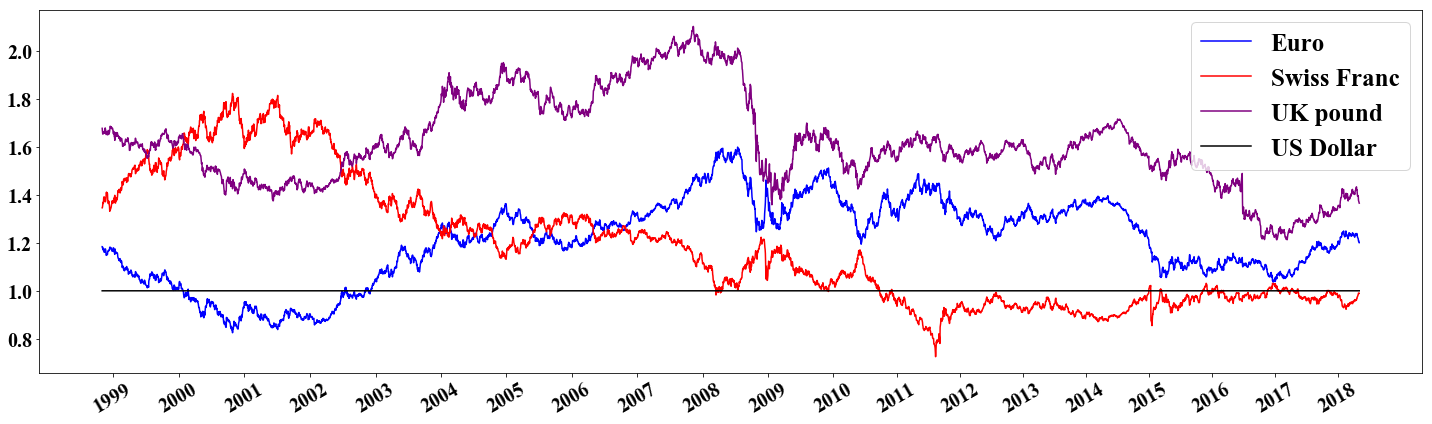

In [32]:
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams["font.family"] = "Times New Roman"

plt.figure(figsize=(20,6))

plt.plot(euro, label="Euro", color='blue')
plt.plot(swiss_franc, label="Swiss Franc", color='red')
plt.plot(UK_pound, label="UK pound", color='purple')
plt.plot(US_dollar, label="US Dollar", color='black')

plt.xticks(year_idxs[1:], year_labels[1:], rotation=30)

plt.legend(prop={'size': 25})
plt.tight_layout()
plt.savefig('currencies.pdf')
plt.show();

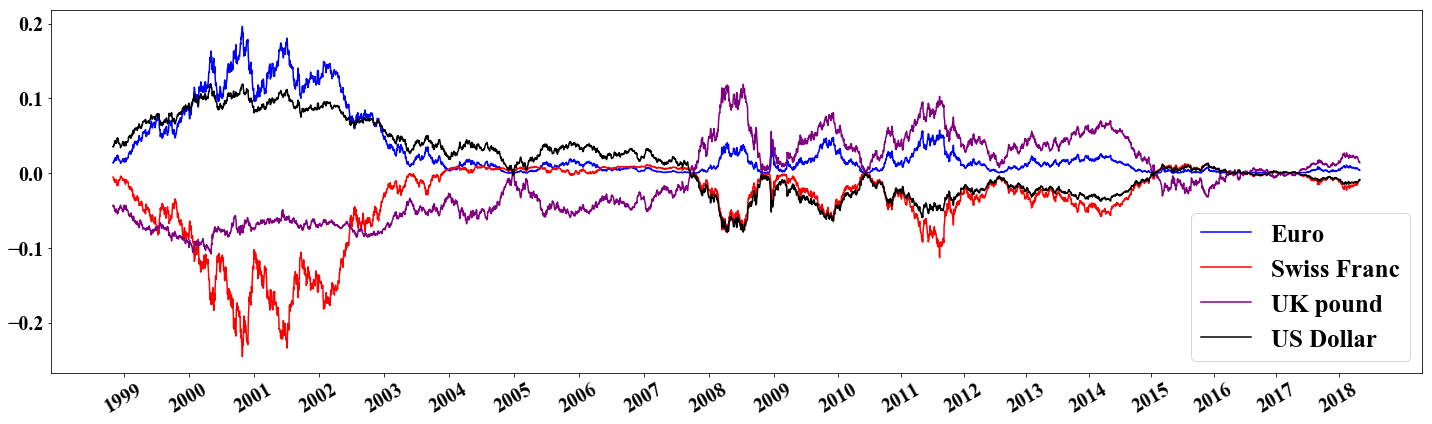

In [33]:
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams["font.family"] = "Times New Roman"

plt.figure(figsize=(20,6))

#plt.plot(var_ad, label="Australian Dollar")
plt.plot(cov_ad_euro, label="Euro", color='blue')
plt.plot(cov_ad_sf, label="Swiss Franc", color='red')
plt.plot(cov_ad_pound, label="UK pound", color='purple')
plt.plot(cov_ad_dollar, label="US Dollar", color='black')
#plt.title("covariances")

plt.xticks(year_idxs[1:], year_labels[1:], rotation=30)

plt.legend(prop={'size': 25})
plt.tight_layout()
plt.savefig('currency_covariances.pdf')
plt.show();

In [34]:
matrices_back = np.array(matrices_back)
x1 = matrices_back[:,0,0]
x2 = matrices_back[:,0,1]
x3 = matrices_back[:,0,2]
x4 = matrices_back[:,0,3]
#x5 = matrices_back[:,0,4]

variances_back = np.array(variances_back)
v1 = np.sqrt(variances_back[:,0,0])
v2 = np.sqrt(variances_back[:,0,1])
v3 = np.sqrt(variances_back[:,0,2])
v4 = np.sqrt(variances_back[:,0,3])
#v5 = np.sqrt(variances_back[:,0,4])

In [35]:
year_months_idxs = np.arange(0+2, 235+12+2, 12)

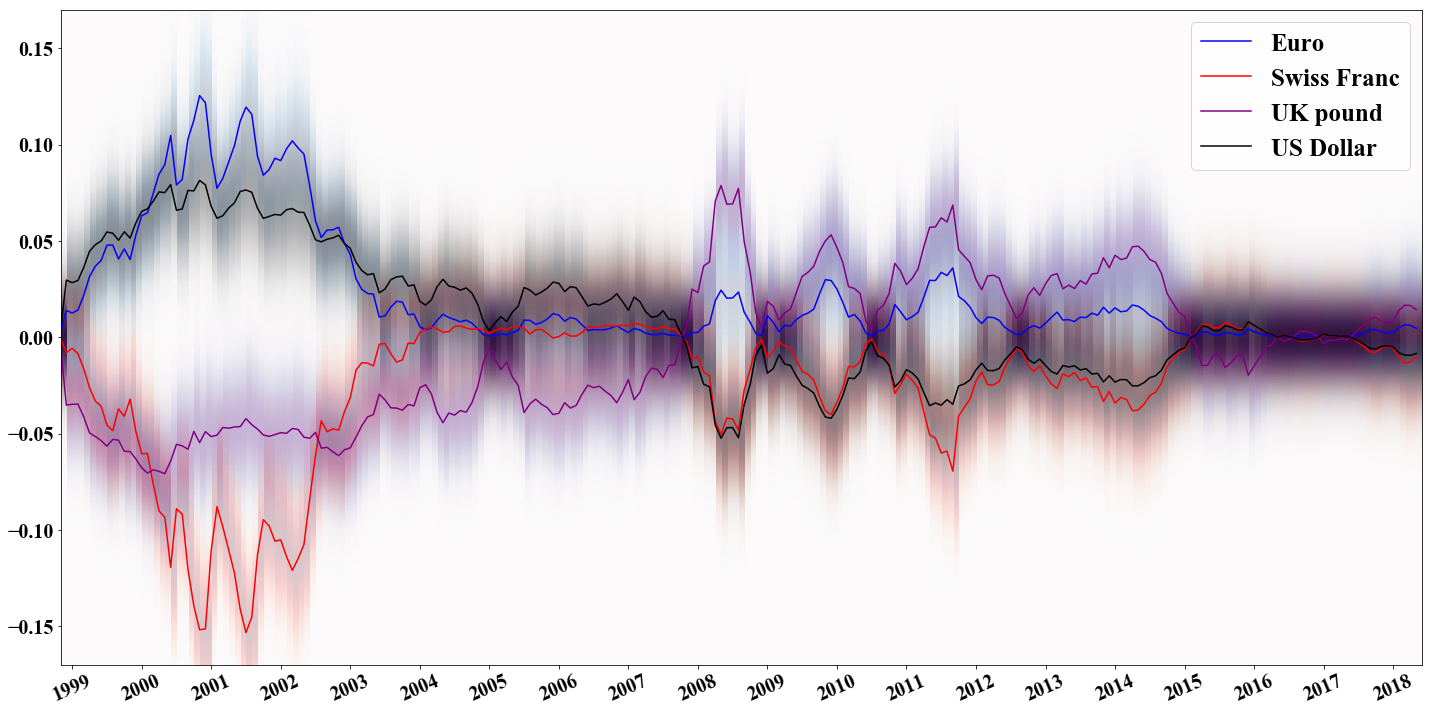

In [36]:
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams["font.family"] = "Times New Roman"

plt.figure(figsize=(20,10))

#plt.plot(x1, label="Australian Dollar")
plt.plot(x1, label="Euro", color='blue')
plt.plot(x2, label="Swiss Franc", color='red')
plt.plot(x3, label="UK pound", color='purple')
plt.plot(x4, label="US Dollar", color='black')

plt.xticks(year_months_idxs, year_labels[1:], rotation = 23)

margin = 0.17

def GaussPDFscaled(y, m, s):  # shading
    return np.exp(-0.5 * (y - m.T) ** 2 / (s ** 2).T)


yy = np.linspace(-margin, margin, 1000).reshape([1000, 1])

Ppost1 = GaussPDFscaled(
    yy, x1, v1
)  # shading by local marginal pdf

Ppost2 = GaussPDFscaled(
    yy, x2, v2
)  # shading by local marginal pdf

Ppost3 = GaussPDFscaled(
    yy, x3, v3
)  # shading by local marginal pdf

Ppost4 = GaussPDFscaled(
    yy, x4, v4
)  # shading by local marginal pdf

plt.imshow(
    Ppost1,
    extent=[0, 235, -margin, margin],
    aspect="auto",
    origin="lower",
    cmap="Blues",
    alpha=0.8,
)

plt.imshow(
    Ppost2,
    extent=[0, 235, -margin, margin],
    aspect="auto",
    origin="lower",
    cmap="Reds",
    alpha=0.5,
)


plt.imshow(
    Ppost3,
    extent=[0, 235, -margin, margin],
    aspect="auto",
    origin="lower",
    cmap="Purples",
    alpha=0.4,
)

plt.imshow(
    Ppost4,
    extent=[0, 235, -margin, margin],
    aspect="auto",
    origin="lower",
    cmap="Greys",
    alpha=0.3,
)



plt.legend(prop={'size': 25})
plt.tight_layout()
plt.savefig('currency_covariances_GP.pdf')
plt.show();

In [39]:
print(np.shape(yy))
print(np.shape(Ppost1))

(1000, 1)
(1000, 235)


# TODOs:
- understand the different effects of kernel hyperparameters. 
- Where does the difference in scaling come from?
- plot 5 currencies in three plots: a) Just the currencies, b) the original covariances c) the GP with standard deviations etc.
